In [1]:
import sys
sys.path.append("../")

from torch import nn
from data_utils import load_mnist, load_usps
from models import DomainAdaptationNetwork

import torch
from torch.nn import functional as F
import numpy as np
from train import train_domain_adaptation
from utils import test_network, plot_target_cross_domain_swapping, plot_tsne

In [2]:
torch.manual_seed(0)
import numpy as np
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_space_dim, conv_feat_size, nb_channels=3):
        super(Decoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.conv_feat_size = conv_feat_size

        self.deco_dense = nn.Sequential(
            nn.Linear(in_features=latent_space_dim, out_features=1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features=np.prod(self.conv_feat_size)),
            nn.ReLU(True),
        )

        self.deco_fetures = nn.Sequential(
            nn.Conv2d(in_channels=self.conv_feat_size[0], out_channels=75, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=75, out_channels=50, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=50, out_channels=1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, z_share, z_spe):
        z = torch.cat([z_share, z_spe], 1)
        feat_encode = self.deco_dense(z)
        feat_encode = feat_encode.view(-1, *self.conv_feat_size)
        y = self.deco_fetures(feat_encode)

        return y


class Encoder(nn.Module):
    def __init__(self, latent_space_dim, img_size, nb_channels=3):
        super(Encoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.nb_channels = nb_channels

        self.conv_feat = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=50, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=50, out_channels=75, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.BatchNorm2d(75),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=75, out_channels=100, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(100),
        )

        self.conv_feat_size = self.conv_feat(torch.zeros(1, *img_size)).shape[1:]
        self.dense_feature_size = np.prod(self.conv_feat_size)

        self.dense_feat = nn.Sequential(
            nn.Linear(in_features=self.dense_feature_size, out_features=1024),
            nn.ReLU(True), )

        self.share_feat = nn.Sequential(
            nn.Linear(in_features=1024, out_features=latent_space_dim),
            nn.ReLU(True),
        )

        self.source_feat = nn.Sequential(
            nn.Linear(in_features=1024, out_features=latent_space_dim),
            nn.ReLU(True),
        )

        self.target_feat = nn.Sequential(
            nn.Linear(in_features=1024, out_features=latent_space_dim),
            nn.ReLU(True),
        )

    def forward(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_share = self.share_feat(feat)
        z_source = self.source_feat(feat)
        z_target = self.target_feat(feat)
        return z_share, z_source, z_target

    def forward_share(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_share = self.share_feat(feat)
        return z_share

    def forward_source(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_source = self.source_feat(feat)
        return z_source

    def forward_target(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_target = self.target_feat(feat)
        return z_target


In [4]:
learning_rate = 5e-4

source_train_loader, source_test_loader =  load_usps(img_size=32, augment=True, batch_size=64, shuffle=True, num_workers=2)
target_train_loader, target_test_loader = load_mnist(img_size=32, augment=True, batch_size=64, shuffle=True, num_workers=2)

encoder = Encoder(latent_space_dim=150, img_size=(1,32,32), nb_channels=1)

conv_feat_size = encoder.conv_feat_size
decoder_source = Decoder(latent_space_dim=300, conv_feat_size=conv_feat_size, nb_channels=1)
decoder_target = Decoder(latent_space_dim=300, conv_feat_size=conv_feat_size, nb_channels=1)

classifier = nn.Sequential(nn.Dropout2d(0),
                         nn.Linear(in_features=150, out_features=10),
                         nn.LogSoftmax())

model = DomainAdaptationNetwork(encoder, decoder_source, decoder_target, classifier).cuda()

optimizer = torch.optim.Adam([
    {'params': model.encoder.parameters()},
    {'params': model.decoder_source.parameters()},
    {'params': model.decoder_target.parameters()},
    {'params': model.classifier.parameters()},
    {'params': model.spe_predictor.parameters()},
    {'params': model.share_predictor.parameters()}], lr=learning_rate, weight_decay=0.001)

epochs = 50
betas = np.linspace(0, 5, epochs)

train_domain_adaptation(model, optimizer, source_train_loader, target_train_loader,
                                            epochs=50, betas=betas, gamma=0.5, delta=0.5)

  0%|          | 0/50 [00:00<?, ?it/s]/home/david/anaconda3/envs/domain_adaptation/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
epoch:0 current target accuracy:49.66%:   2%|▏         | 1/50 [00:09<07:51,  9.62s/it]

epoch [1/50], loss:1.6127
accuracy source: 89.49%
accuracy target: 49.63%


epoch:1 current target accuracy:70.28%:   4%|▍         | 2/50 [00:18<07:35,  9.48s/it]

epoch [2/50], loss:1.1481
accuracy source: 96.85%
accuracy target: 70.23%


epoch:2 current target accuracy:78.15%:   6%|▌         | 3/50 [00:27<07:19,  9.36s/it]

epoch [3/50], loss:1.0096
accuracy source: 98.02%
accuracy target: 78.1%


epoch:3 current target accuracy:82.8%:   8%|▊         | 4/50 [00:36<07:05,  9.25s/it] 

epoch [4/50], loss:0.9612
accuracy source: 98.51%
accuracy target: 82.74%


epoch:4 current target accuracy:83.94%:  10%|█         | 5/50 [00:45<06:53,  9.20s/it]

epoch [5/50], loss:0.9302
accuracy source: 98.57%
accuracy target: 83.88%


epoch:5 current target accuracy:85.31%:  12%|█▏        | 6/50 [00:54<06:42,  9.15s/it]

epoch [6/50], loss:0.8904
accuracy source: 98.77%
accuracy target: 85.25%


epoch:6 current target accuracy:87.12%:  14%|█▍        | 7/50 [01:04<06:32,  9.13s/it]

epoch [7/50], loss:0.8804
accuracy source: 98.74%
accuracy target: 87.06%


epoch:7 current target accuracy:89.55%:  16%|█▌        | 8/50 [01:13<06:22,  9.11s/it]

epoch [8/50], loss:0.8774
accuracy source: 98.93%
accuracy target: 89.49%


epoch:8 current target accuracy:90.0%:  18%|█▊        | 9/50 [01:22<06:14,  9.13s/it] 

epoch [9/50], loss:0.8495
accuracy source: 98.74%
accuracy target: 89.94%


epoch:9 current target accuracy:91.21%:  20%|██        | 10/50 [01:31<06:05,  9.14s/it]

epoch [10/50], loss:0.8399
accuracy source: 98.93%
accuracy target: 91.15%


epoch:10 current target accuracy:92.29%:  22%|██▏       | 11/50 [01:40<05:56,  9.13s/it]

epoch [11/50], loss:0.8110
accuracy source: 99.0%
accuracy target: 92.23%


epoch:11 current target accuracy:92.79%:  24%|██▍       | 12/50 [01:49<05:47,  9.13s/it]

epoch [12/50], loss:0.7987
accuracy source: 99.16%
accuracy target: 92.72%


epoch:12 current target accuracy:91.7%:  26%|██▌       | 13/50 [01:58<05:39,  9.16s/it] 

epoch [13/50], loss:0.7962
accuracy source: 98.97%
accuracy target: 91.64%


epoch:13 current target accuracy:93.09%:  28%|██▊       | 14/50 [02:08<05:29,  9.16s/it]

epoch [14/50], loss:0.7772
accuracy source: 99.26%
accuracy target: 93.02%


epoch:14 current target accuracy:92.92%:  30%|███       | 15/50 [02:17<05:21,  9.18s/it]

epoch [15/50], loss:0.7819
accuracy source: 99.11%
accuracy target: 92.86%


epoch:15 current target accuracy:92.59%:  32%|███▏      | 16/50 [02:26<05:12,  9.19s/it]

epoch [16/50], loss:0.7585
accuracy source: 99.2%
accuracy target: 92.53%


epoch:16 current target accuracy:93.87%:  34%|███▍      | 17/50 [02:35<05:04,  9.22s/it]

epoch [17/50], loss:0.7596
accuracy source: 99.08%
accuracy target: 93.8%


epoch:17 current target accuracy:93.54%:  36%|███▌      | 18/50 [02:45<04:55,  9.24s/it]

epoch [18/50], loss:0.7412
accuracy source: 99.31%
accuracy target: 93.48%


epoch:18 current target accuracy:92.99%:  38%|███▊      | 19/50 [02:54<04:49,  9.32s/it]

epoch [19/50], loss:0.7278
accuracy source: 99.31%
accuracy target: 92.93%


epoch:19 current target accuracy:92.79%:  40%|████      | 20/50 [03:03<04:39,  9.31s/it]

epoch [20/50], loss:0.7295
accuracy source: 99.27%
accuracy target: 92.72%


epoch:20 current target accuracy:92.07%:  42%|████▏     | 21/50 [03:13<04:32,  9.41s/it]

epoch [21/50], loss:0.7218
accuracy source: 99.34%
accuracy target: 92.01%


epoch:21 current target accuracy:93.25%:  44%|████▍     | 22/50 [03:23<04:25,  9.49s/it]

epoch [22/50], loss:0.7225
accuracy source: 99.33%
accuracy target: 93.19%


epoch:22 current target accuracy:93.94%:  46%|████▌     | 23/50 [03:32<04:15,  9.46s/it]

epoch [23/50], loss:0.7155
accuracy source: 99.31%
accuracy target: 93.87%


epoch:23 current target accuracy:94.79%:  48%|████▊     | 24/50 [03:42<04:07,  9.51s/it]

epoch [24/50], loss:0.7217
accuracy source: 99.27%
accuracy target: 94.72%


epoch:24 current target accuracy:93.83%:  50%|█████     | 25/50 [03:51<03:58,  9.54s/it]

epoch [25/50], loss:0.7181
accuracy source: 99.27%
accuracy target: 93.76%


epoch:25 current target accuracy:94.2%:  52%|█████▏    | 26/50 [04:01<03:49,  9.56s/it] 

epoch [26/50], loss:0.6969
accuracy source: 99.36%
accuracy target: 94.13%


epoch:26 current target accuracy:93.95%:  54%|█████▍    | 27/50 [04:10<03:38,  9.50s/it]

epoch [27/50], loss:0.6998
accuracy source: 99.27%
accuracy target: 93.89%


epoch:27 current target accuracy:93.18%:  56%|█████▌    | 28/50 [04:20<03:29,  9.54s/it]

epoch [28/50], loss:0.7153
accuracy source: 99.2%
accuracy target: 93.12%


epoch:28 current target accuracy:93.64%:  58%|█████▊    | 29/50 [04:29<03:20,  9.54s/it]

epoch [29/50], loss:0.6932
accuracy source: 99.42%
accuracy target: 93.57%


epoch:29 current target accuracy:94.61%:  60%|██████    | 30/50 [04:39<03:09,  9.48s/it]

epoch [30/50], loss:0.6884
accuracy source: 99.42%
accuracy target: 94.54%


epoch:30 current target accuracy:94.54%:  62%|██████▏   | 31/50 [04:48<03:00,  9.48s/it]

epoch [31/50], loss:0.6794
accuracy source: 99.51%
accuracy target: 94.48%


epoch:31 current target accuracy:94.01%:  64%|██████▍   | 32/50 [04:58<02:50,  9.46s/it]

epoch [32/50], loss:0.6794
accuracy source: 99.34%
accuracy target: 93.94%


epoch:32 current target accuracy:91.52%:  66%|██████▌   | 33/50 [05:07<02:41,  9.51s/it]

epoch [33/50], loss:0.6946
accuracy source: 99.18%
accuracy target: 91.46%


epoch:33 current target accuracy:92.61%:  68%|██████▊   | 34/50 [05:17<02:31,  9.49s/it]

epoch [34/50], loss:0.6753
accuracy source: 99.41%
accuracy target: 92.54%


epoch:34 current target accuracy:93.83%:  70%|███████   | 35/50 [05:26<02:21,  9.45s/it]

epoch [35/50], loss:0.6630
accuracy source: 99.47%
accuracy target: 93.76%


epoch:35 current target accuracy:93.58%:  72%|███████▏  | 36/50 [05:36<02:13,  9.57s/it]

epoch [36/50], loss:0.6367
accuracy source: 99.64%
accuracy target: 93.52%


epoch:36 current target accuracy:93.11%:  74%|███████▍  | 37/50 [05:46<02:04,  9.59s/it]

epoch [37/50], loss:0.6568
accuracy source: 99.52%
accuracy target: 93.05%


epoch:37 current target accuracy:93.54%:  76%|███████▌  | 38/50 [05:55<01:54,  9.53s/it]

epoch [38/50], loss:0.6702
accuracy source: 99.42%
accuracy target: 93.48%


epoch:38 current target accuracy:94.42%:  78%|███████▊  | 39/50 [06:04<01:44,  9.51s/it]

epoch [39/50], loss:0.6755
accuracy source: 99.36%
accuracy target: 94.35%


epoch:39 current target accuracy:94.45%:  80%|████████  | 40/50 [06:15<01:36,  9.68s/it]

epoch [40/50], loss:0.6422
accuracy source: 99.55%
accuracy target: 94.38%


epoch:40 current target accuracy:94.98%:  82%|████████▏ | 41/50 [06:24<01:26,  9.63s/it]

epoch [41/50], loss:0.6341
accuracy source: 99.57%
accuracy target: 94.92%


epoch:41 current target accuracy:95.53%:  84%|████████▍ | 42/50 [06:34<01:17,  9.74s/it]

epoch [42/50], loss:0.6473
accuracy source: 99.42%
accuracy target: 95.46%


epoch:42 current target accuracy:95.1%:  86%|████████▌ | 43/50 [06:44<01:07,  9.71s/it] 

epoch [43/50], loss:0.6506
accuracy source: 99.51%
accuracy target: 95.04%


epoch:43 current target accuracy:95.78%:  88%|████████▊ | 44/50 [06:53<00:57,  9.59s/it]

epoch [44/50], loss:0.6310
accuracy source: 99.67%
accuracy target: 95.71%


epoch:44 current target accuracy:95.82%:  90%|█████████ | 45/50 [07:02<00:47,  9.51s/it]

epoch [45/50], loss:0.6436
accuracy source: 99.66%
accuracy target: 95.75%


epoch:45 current target accuracy:95.17%:  92%|█████████▏| 46/50 [07:12<00:37,  9.47s/it]

epoch [46/50], loss:0.6620
accuracy source: 99.37%
accuracy target: 95.11%


epoch:46 current target accuracy:95.97%:  94%|█████████▍| 47/50 [07:21<00:28,  9.46s/it]

epoch [47/50], loss:0.6742
accuracy source: 99.49%
accuracy target: 95.9%


epoch:47 current target accuracy:96.19%:  96%|█████████▌| 48/50 [07:31<00:19,  9.60s/it]

epoch [48/50], loss:0.6297
accuracy source: 99.67%
accuracy target: 96.12%


epoch:48 current target accuracy:95.64%:  98%|█████████▊| 49/50 [07:40<00:09,  9.52s/it]

epoch [49/50], loss:0.6522
accuracy source: 99.47%
accuracy target: 95.57%


epoch:49 current target accuracy:96.19%: 100%|██████████| 50/50 [07:50<00:00,  9.41s/it]

epoch [50/50], loss:0.6609
accuracy source: 99.42%
accuracy target: 96.12%


In [5]:
model.eval()
test_network(model, target_test_loader) 

0.9751

In [6]:
optimizer = torch.optim.Adam([
    {'params': model.encoder.parameters()},
    {'params': model.decoder_source.parameters()},
    {'params': model.decoder_target.parameters()},
    {'params': model.classifier.parameters()},
    {'params': model.spe_predictor.parameters()},
    {'params': model.share_predictor.parameters()}], lr=5e-5, weight_decay=0.001)

epochs = 50
betas = np.ones(epochs) * 5

train_domain_adaptation(model, optimizer, source_train_loader, target_train_loader,
                                            epochs=50, betas=betas, gamma=0.5, delta=0.5)

epoch:0 current target accuracy:96.06%:   2%|▏         | 1/50 [00:09<07:30,  9.20s/it]

epoch [1/50], loss:0.6487
accuracy source: 99.48%
accuracy target: 96.0%


epoch:1 current target accuracy:96.2%:   4%|▍         | 2/50 [00:18<07:19,  9.15s/it] 

epoch [2/50], loss:0.6000
accuracy source: 99.62%
accuracy target: 96.13%


epoch:2 current target accuracy:96.37%:   6%|▌         | 3/50 [00:27<07:08,  9.11s/it]

epoch [3/50], loss:0.5901
accuracy source: 99.68%
accuracy target: 96.3%


epoch:3 current target accuracy:96.2%:   8%|▊         | 4/50 [00:36<06:58,  9.10s/it] 

epoch [4/50], loss:0.5826
accuracy source: 99.74%
accuracy target: 96.13%


epoch:4 current target accuracy:96.93%:  10%|█         | 5/50 [00:45<06:56,  9.26s/it]

epoch [5/50], loss:0.5806
accuracy source: 99.66%
accuracy target: 96.86%


epoch:5 current target accuracy:97.15%:  12%|█▏        | 6/50 [00:55<06:47,  9.25s/it]

epoch [6/50], loss:0.5701
accuracy source: 99.77%
accuracy target: 97.08%


epoch:6 current target accuracy:97.2%:  14%|█▍        | 7/50 [01:04<06:44,  9.40s/it] 

epoch [7/50], loss:0.5695
accuracy source: 99.74%
accuracy target: 97.14%


epoch:7 current target accuracy:96.83%:  16%|█▌        | 8/50 [01:14<06:37,  9.47s/it]

epoch [8/50], loss:0.5624
accuracy source: 99.84%
accuracy target: 96.77%


epoch:8 current target accuracy:97.2%:  18%|█▊        | 9/50 [01:23<06:26,  9.42s/it] 

epoch [9/50], loss:0.5626
accuracy source: 99.85%
accuracy target: 97.14%


epoch:9 current target accuracy:97.13%:  20%|██        | 10/50 [01:34<06:25,  9.65s/it]

epoch [10/50], loss:0.5587
accuracy source: 99.84%
accuracy target: 97.07%


epoch:10 current target accuracy:97.48%:  22%|██▏       | 11/50 [01:43<06:19,  9.73s/it]

epoch [11/50], loss:0.5613
accuracy source: 99.78%
accuracy target: 97.41%


epoch:11 current target accuracy:97.6%:  24%|██▍       | 12/50 [01:53<06:09,  9.72s/it] 

epoch [12/50], loss:0.5600
accuracy source: 99.77%
accuracy target: 97.53%


epoch:12 current target accuracy:97.01%:  26%|██▌       | 13/50 [02:02<05:52,  9.52s/it]

epoch [13/50], loss:0.5569
accuracy source: 99.81%
accuracy target: 96.94%


epoch:13 current target accuracy:97.11%:  28%|██▊       | 14/50 [02:12<05:44,  9.58s/it]

epoch [14/50], loss:0.5584
accuracy source: 99.82%
accuracy target: 97.04%


epoch:14 current target accuracy:97.49%:  30%|███       | 15/50 [02:21<05:33,  9.53s/it]

epoch [15/50], loss:0.5518
accuracy source: 99.85%
accuracy target: 97.42%


epoch:15 current target accuracy:97.34%:  32%|███▏      | 16/50 [02:30<05:19,  9.40s/it]

epoch [16/50], loss:0.5517
accuracy source: 99.81%
accuracy target: 97.27%


epoch:16 current target accuracy:97.34%:  34%|███▍      | 17/50 [02:40<05:13,  9.50s/it]

epoch [17/50], loss:0.5508
accuracy source: 99.88%
accuracy target: 97.27%


epoch:17 current target accuracy:97.24%:  36%|███▌      | 18/50 [02:49<04:59,  9.37s/it]

epoch [18/50], loss:0.5482
accuracy source: 99.84%
accuracy target: 97.18%


epoch:18 current target accuracy:97.11%:  38%|███▊      | 19/50 [02:58<04:48,  9.32s/it]

epoch [19/50], loss:0.5487
accuracy source: 99.82%
accuracy target: 97.04%


epoch:19 current target accuracy:97.23%:  40%|████      | 20/50 [03:08<04:38,  9.28s/it]

epoch [20/50], loss:0.5523
accuracy source: 99.75%
accuracy target: 97.16%


epoch:20 current target accuracy:97.78%:  42%|████▏     | 21/50 [03:18<04:34,  9.46s/it]

epoch [21/50], loss:0.5422
accuracy source: 99.89%
accuracy target: 97.71%


epoch:21 current target accuracy:97.64%:  44%|████▍     | 22/50 [03:27<04:21,  9.35s/it]

epoch [22/50], loss:0.5462
accuracy source: 99.82%
accuracy target: 97.57%


epoch:22 current target accuracy:97.09%:  46%|████▌     | 23/50 [03:36<04:16,  9.49s/it]

epoch [23/50], loss:0.5506
accuracy source: 99.77%
accuracy target: 97.03%


epoch:23 current target accuracy:97.71%:  48%|████▊     | 24/50 [03:46<04:03,  9.38s/it]

epoch [24/50], loss:0.5419
accuracy source: 99.88%
accuracy target: 97.64%


epoch:24 current target accuracy:97.53%:  50%|█████     | 25/50 [03:55<03:52,  9.30s/it]

epoch [25/50], loss:0.5443
accuracy source: 99.81%
accuracy target: 97.46%


epoch:25 current target accuracy:97.6%:  52%|█████▏    | 26/50 [04:04<03:46,  9.42s/it] 

epoch [26/50], loss:0.5432
accuracy source: 99.84%
accuracy target: 97.53%


epoch:26 current target accuracy:97.46%:  54%|█████▍    | 27/50 [04:13<03:34,  9.31s/it]

epoch [27/50], loss:0.5431
accuracy source: 99.84%
accuracy target: 97.4%


epoch:27 current target accuracy:97.75%:  56%|█████▌    | 28/50 [04:23<03:23,  9.27s/it]

epoch [28/50], loss:0.5389
accuracy source: 99.86%
accuracy target: 97.68%


epoch:28 current target accuracy:97.31%:  58%|█████▊    | 29/50 [04:32<03:14,  9.26s/it]

epoch [29/50], loss:0.5441
accuracy source: 99.84%
accuracy target: 97.25%


epoch:29 current target accuracy:97.23%:  60%|██████    | 30/50 [04:42<03:08,  9.45s/it]

epoch [30/50], loss:0.5426
accuracy source: 99.81%
accuracy target: 97.16%


epoch:30 current target accuracy:97.76%:  62%|██████▏   | 31/50 [04:51<02:57,  9.35s/it]

epoch [31/50], loss:0.5365
accuracy source: 99.86%
accuracy target: 97.7%


epoch:31 current target accuracy:97.34%:  64%|██████▍   | 32/50 [05:01<02:50,  9.45s/it]

epoch [32/50], loss:0.5395
accuracy source: 99.82%
accuracy target: 97.27%


epoch:32 current target accuracy:97.96%:  66%|██████▌   | 33/50 [05:10<02:38,  9.33s/it]

epoch [33/50], loss:0.5352
accuracy source: 99.88%
accuracy target: 97.89%


epoch:33 current target accuracy:97.7%:  68%|██████▊   | 34/50 [05:19<02:28,  9.30s/it] 

epoch [34/50], loss:0.5344
accuracy source: 99.9%
accuracy target: 97.63%


epoch:34 current target accuracy:97.59%:  70%|███████   | 35/50 [05:28<02:19,  9.27s/it]

epoch [35/50], loss:0.5322
accuracy source: 99.9%
accuracy target: 97.52%


epoch:35 current target accuracy:97.94%:  72%|███████▏  | 36/50 [05:37<02:09,  9.26s/it]

epoch [36/50], loss:0.5339
accuracy source: 99.82%
accuracy target: 97.88%


epoch:36 current target accuracy:97.61%:  74%|███████▍  | 37/50 [05:47<02:00,  9.27s/it]

epoch [37/50], loss:0.5300
accuracy source: 99.9%
accuracy target: 97.55%


epoch:37 current target accuracy:97.93%:  76%|███████▌  | 38/50 [05:56<01:53,  9.45s/it]

epoch [38/50], loss:0.5329
accuracy source: 99.89%
accuracy target: 97.86%


epoch:38 current target accuracy:97.85%:  78%|███████▊  | 39/50 [06:06<01:43,  9.45s/it]

epoch [39/50], loss:0.5348
accuracy source: 99.89%
accuracy target: 97.78%


epoch:39 current target accuracy:97.94%:  80%|████████  | 40/50 [06:15<01:34,  9.43s/it]

epoch [40/50], loss:0.5322
accuracy source: 99.88%
accuracy target: 97.88%


epoch:40 current target accuracy:97.92%:  82%|████████▏ | 41/50 [06:25<01:24,  9.39s/it]

epoch [41/50], loss:0.5309
accuracy source: 99.89%
accuracy target: 97.85%


epoch:41 current target accuracy:98.02%:  84%|████████▍ | 42/50 [06:34<01:14,  9.28s/it]

epoch [42/50], loss:0.5294
accuracy source: 99.88%
accuracy target: 97.96%


epoch:42 current target accuracy:97.74%:  86%|████████▌ | 43/50 [06:43<01:06,  9.47s/it]

epoch [43/50], loss:0.5296
accuracy source: 99.9%
accuracy target: 97.67%


epoch:43 current target accuracy:97.63%:  88%|████████▊ | 44/50 [06:53<00:56,  9.37s/it]

epoch [44/50], loss:0.5315
accuracy source: 99.85%
accuracy target: 97.56%


epoch:44 current target accuracy:97.63%:  90%|█████████ | 45/50 [07:02<00:47,  9.43s/it]

epoch [45/50], loss:0.5320
accuracy source: 99.86%
accuracy target: 97.56%


epoch:45 current target accuracy:98.19%:  92%|█████████▏| 46/50 [07:11<00:37,  9.32s/it]

epoch [46/50], loss:0.5320
accuracy source: 99.86%
accuracy target: 98.12%


epoch:46 current target accuracy:98.09%:  94%|█████████▍| 47/50 [07:21<00:28,  9.39s/it]

epoch [47/50], loss:0.5253
accuracy source: 99.84%
accuracy target: 98.03%


epoch:47 current target accuracy:97.92%:  96%|█████████▌| 48/50 [07:30<00:18,  9.35s/it]

epoch [48/50], loss:0.5274
accuracy source: 99.84%
accuracy target: 97.85%


epoch:48 current target accuracy:97.63%:  98%|█████████▊| 49/50 [07:39<00:09,  9.28s/it]

epoch [49/50], loss:0.5302
accuracy source: 99.82%
accuracy target: 97.56%


epoch:49 current target accuracy:97.86%: 100%|██████████| 50/50 [07:49<00:00,  9.39s/it]

epoch [50/50], loss:0.5279
accuracy source: 99.86%
accuracy target: 97.79%


In [8]:
model.eval()
test_network(model, target_test_loader)  

/home/david/anaconda3/envs/domain_adaptation/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.9882

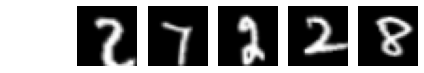

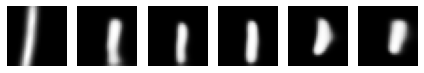

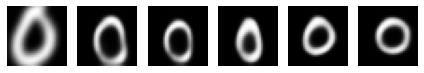

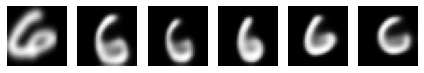

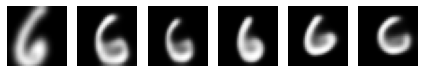

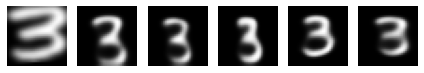

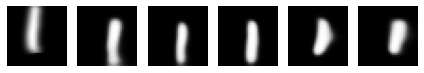

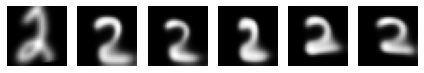

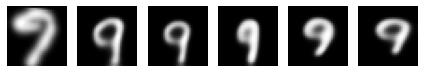

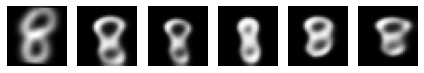

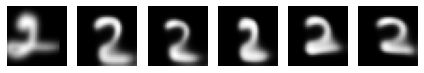

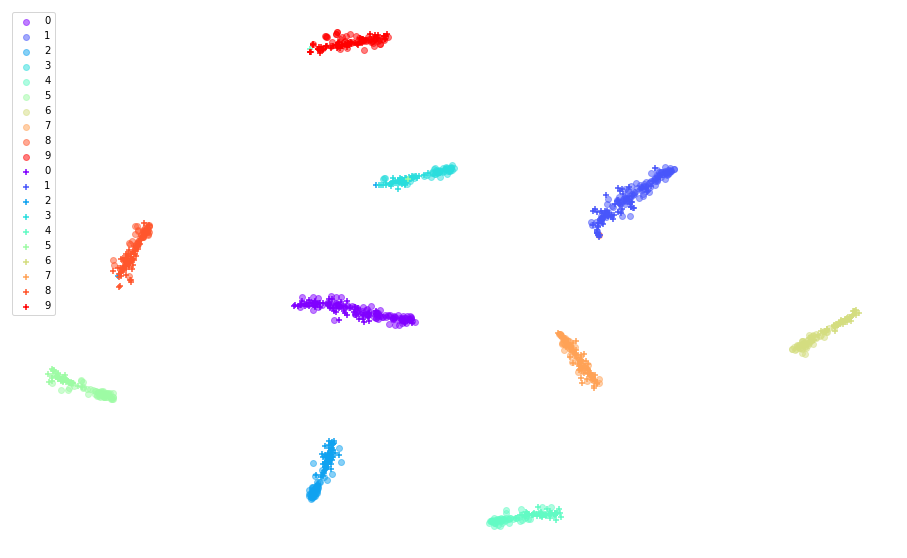

In [7]:
plot_target_cross_domain_swapping(model, source_train_loader, target_train_loader)
plot_tsne(model, source_train_loader, target_train_loader, batch_size=64, feature_size=150)

In [9]:
torch.save(model, "usps_to_mnist.pth")

/home/david/anaconda3/envs/domain_adaptation/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/david/anaconda3/envs/domain_adaptation/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
